Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [7]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [8]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [9]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Using L2 Normalization on Logistic Regression with SGD. I got 85.6% without, lets see how we can improve this.

In [21]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [22]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.372068
Minibatch accuracy: 10.9%
Validation accuracy: 11.9%
Minibatch loss at step 500: 3.218160
Minibatch accuracy: 68.0%
Validation accuracy: 76.3%
Minibatch loss at step 1000: 1.737247
Minibatch accuracy: 76.6%
Validation accuracy: 78.5%
Minibatch loss at step 1500: 1.311618
Minibatch accuracy: 76.6%
Validation accuracy: 80.3%
Minibatch loss at step 2000: 0.942690
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.908568
Minibatch accuracy: 82.0%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 0.639621
Minibatch accuracy: 85.9%
Validation accuracy: 82.1%
Test accuracy: 88.5%


Since we can tune the beta_regularization parameter using the valisdation set; lets do that to find the best beta_regul

In [9]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for beta_val in regul_val:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
#        if (step % 500 == 0):
#           print("Minibatch loss at step %d: %f" % (step, l))
#           print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#           print("Validation accuracy: %.1f%%" % accuracy(
#             valid_prediction.eval(), valid_labels))
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


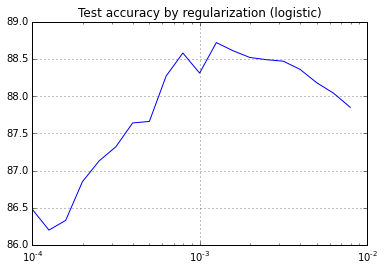

In [13]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Lets use L2 Regularization for the 1-layer Neural Network

In [23]:
batch_size = 128
image_size = 28
num_hidden_nodes = 1024
num_labels = 10
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset , weights_1) +biases_1)
  logits = tf.matmul(layer_1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta_regul * (tf.nn.l2_loss(weights_1) +
                                                                                                    tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights_2) + biases_2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights_2) + biases_2)

In [18]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
for beta_val in regul_val:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
#        if (step % 500 == 0):
#           print("Minibatch loss at step %d: %f" % (step, l))
#           print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
#           print("Validation accuracy: %.1f%%" % accuracy(
#             valid_prediction.eval(), valid_labels))
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


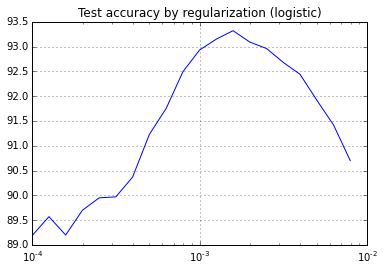

In [19]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Running the NN with the best regularization parameters

In [24]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 2*1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 919.338623
Minibatch accuracy: 9.4%
Validation accuracy: 27.8%
Minibatch loss at step 500: 230.767700
Minibatch accuracy: 75.0%
Validation accuracy: 77.4%
Minibatch loss at step 1000: 83.342163
Minibatch accuracy: 84.4%
Validation accuracy: 82.7%
Minibatch loss at step 1500: 30.824114
Minibatch accuracy: 80.5%
Validation accuracy: 85.7%
Minibatch loss at step 2000: 11.716578
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%
Minibatch loss at step 2500: 4.700340
Minibatch accuracy: 85.2%
Validation accuracy: 86.8%
Minibatch loss at step 3000: 1.977905
Minibatch accuracy: 90.6%
Validation accuracy: 87.2%
Test accuracy: 92.9%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
num_steps = 3001
num_of_batch = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = step % num_of_batch
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 359.799744
Minibatch accuracy: 10.2%
Validation accuracy: 29.4%
Minibatch loss at step 0: 1253.651978
Minibatch accuracy: 34.4%
Validation accuracy: 37.9%
Minibatch loss at step 0: 110.020088
Minibatch accuracy: 68.8%
Validation accuracy: 72.2%
Minibatch loss at step 0: 24.571081
Minibatch accuracy: 89.1%
Validation accuracy: 74.2%
Minibatch loss at step 0: 2.115981
Minibatch accuracy: 96.1%
Validation accuracy: 73.8%
Minibatch loss at step 0: 0.788447
Minibatch accuracy: 99.2%
Validation accuracy: 74.2%
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibatch loss at step 0: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.4%
Minibat

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [ ]:
Tried running the overfitting model with dropout and L2 regularization. Get improvement from 66% to 74%

In [ ]:
batch_size = 128
image_size = 28
num_hidden_nodes = 1024
num_labels = 10
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset , weights_1) +biases_1)
  drop_1 = tf.nn.dropout(layer_1, 0.5)
  logits = tf.matmul(drop_1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta_regul * (tf.nn.l2_loss(weights_1) +
                                                                                                    tf.nn.l2_loss(weights_2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights_2) + biases_2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights_2) + biases_2)

In [30]:
num_steps = 3001
#num_of_batch = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #step = step % num_of_batch
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_of_batch
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regul : 2*1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1138.038696
Minibatch accuracy: 11.7%
Validation accuracy: 32.2%
Minibatch loss at step 500: 237.283295
Minibatch accuracy: 75.0%
Validation accuracy: 80.0%
Minibatch loss at step 1000: 85.434135
Minibatch accuracy: 78.1%
Validation accuracy: 81.4%
Minibatch loss at step 1500: 30.897116
Minibatch accuracy: 79.7%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 11.768378
Minibatch accuracy: 84.4%
Validation accuracy: 85.7%
Minibatch loss at step 2500: 4.809886
Minibatch accuracy: 82.0%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 2.073448
Minibatch accuracy: 89.1%
Validation accuracy: 86.0%
Test accuracy: 92.2%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


I will try a 3 layered neural net with drop out and L@ regularization. Also , Like suggested in the video s, I will try to use a low variance distribution to initialize the weights.

In [12]:
batch_size = 128
image_size = 28
num_hidden_nodes_1 = 1024
num_hidden_nodes_2 = 256
num_hidden_nodes_3 = 128

num_labels = 10
beta_regul = 1e-3
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #beta_regul = tf.placeholder(tf.float32)
  global_step = tf.Variable(0)
  
  # Variables.
  weights_1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes_1],stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases_1 = tf.Variable(tf.zeros([num_hidden_nodes_1]))
  weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes_1, num_hidden_nodes_2],stddev=np.sqrt(2.0 / (num_hidden_nodes_1))))
  biases_2 = tf.Variable(tf.zeros([num_hidden_nodes_2]))
  weights_3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes_2, num_hidden_nodes_3],stddev=np.sqrt(2.0 / (num_hidden_nodes_2))))
  biases_3 = tf.Variable(tf.zeros([num_hidden_nodes_3]))
  weights_4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes_3, num_labels],stddev=np.sqrt(2.0 / (num_hidden_nodes_3))))
  biases_4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset , weights_1) +biases_1)
  drop_1 = tf.nn.dropout(layer_1, 0.5)
  layer_2 = tf.nn.relu(tf.matmul(drop_1, weights_2) + biases_2)
  drop_2 = tf.nn.dropout(layer_2,0.5)
  layer_3 = tf.nn.relu(tf.matmul(drop_2, weights_3) + biases_3)
  logits = tf.matmul(layer_3, weights_4) + biases_4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
      beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3)+tf.nn.l2_loss(weights_4))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights_2) + biases_2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights_3) + biases_3)

  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights_4) +biases_4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights_2) + biases_2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights_3) + biases_3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights_4) + biases_4)

In [ ]:
num_steps = 20001
#num_of_batch = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #step = step % num_of_batch
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_of_batch
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.655272
Minibatch accuracy: 8.6%
Validation accuracy: 19.0%
Minibatch loss at step 1000: 1.023298
Minibatch accuracy: 82.0%
Validation accuracy: 85.1%
Minibatch loss at step 2000: 0.758131
Minibatch accuracy: 83.6%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 0.609870
Minibatch accuracy: 88.3%
Validation accuracy: 86.9%
Minibatch loss at step 4000: 0.649047
Minibatch accuracy: 81.2%
Validation accuracy: 87.6%
Minibatch loss at step 5000: 0.563694
Minibatch accuracy: 85.9%
Validation accuracy: 87.6%
Minibatch loss at step 6000: 0.645673
Minibatch accuracy: 82.0%
Validation accuracy: 88.0%
Minibatch loss at step 7000: 0.498804
Minibatch accuracy: 93.0%
Validation accuracy: 88.0%
Minibatch loss at step 8000: 0.460752